In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Mon Sep  9 14:27:04 PDT 2019


In [2]:
# set random seed for reproducibility
np.random.seed(12345)

# EPL Examples

## Data Generation

I generated a synthetic population of $N$ individuals, each with a location specified by $J$ hierarchically nested levels, designed to have an average of $\mu$ individuals per location.
I represented this database as matrix $D$ with $N$ rows and $J$ columns, where row $D_i$ represented the hierarchically nested location of individual $i$.
To assign the location, for each individual $i$, for each level of the spatial hierarchy $j$, I sampled the location uniformly,  $D_{ij} \sim_{\mathcal{U}} \{0, 1, \ldots, C-1\}$ where $C = \left\lfloor \left(N/\mu\right)^{1/J} \right\rfloor$ is the number of children for every areal unit in the spatial hierarchy before level $J$.


In [3]:
N = 1_000_000  # number of individuals
mu = 100  # average population
J = 3  # levels of hierarchy

C = int(np.floor((N/mu) ** (1/J)))

df = pd.DataFrame(index=range(N))
for j in range(J):
    df[f'area_{j}'] = np.random.choice(range(C), size=N)

df['weight'] = 1

## Exact counts

To find the exact total count (TC) for each location at any level of the spatial hierarchy, I grouped the database $D$ by spatial area and counted how many individuals were in each areal unit:
$$
\mathrm{TC}_{j_1, j_2, \ldots, j_{J'}} = \sum_i \mathbf{1}\left[
D_{i,1} = j_1 \wedge 
D_{i,2} = j_2 \wedge 
\ldots
D_{i,J'} = j_{J'}
\right].
$$


In [4]:
exact_counts = df.groupby([f'area_{j}' for j in range(J)]).weight.sum()
exact_counts

area_0  area_1  area_2
0       0       0         109
                1         124
                2         122
                3         111
                         ... 
20      20      17        113
                18        114
                19        109
                20        113
Name: weight, Length: 9261, dtype: int64

## Geometric Mechanism:

To generate $\epsilon$-DP counts from exact counts, I used the geometric mechanism to add noise to the exact counts for the most fine-grained areas in the spatial hierarchy (abbreviated GDPC for geometric DP count):
$$
\mathrm{GDPC}_{j_1, j_2, \ldots, j_{J}} = \mathrm{TC}_{j_1, j_2, \ldots, j_{J}} + X_{j_1, j_2, \ldots, j_{J}},
$$
where $X_{j_1, j_2, \ldots, j_{J}} \sim G(\epsilon)$ is drawn from a two-tailed geometric distribution with parameter $\epsilon$, defined by the following equation
$$\Pr[G(z)=k] = \frac{(1 - \exp(-z))\exp(-z|k|)}{1 + \exp(-z)}.$$
The output of this algorithm is the list of $
\mathrm{GDPC}_{j_1, j_2, \ldots, j_{J}}$ values for all tuples $(j_1, j_2, \ldots, j_{J})$.


In [5]:
def GDPC(epsilon, exact_counts):
    """ Geometric DP Counts
    Parameters
    ----------
    epsilon : float-able
    exact_counts : pd.Series
    
    Results
    -------
    returns dp_counts, a pd.Series with index matching exact_counts"""
    
    z = float(epsilon)

    all_errors = (np.random.geometric(z, size=len(exact_counts))
                    - np.random.geometric(z, size=len(exact_counts)))
    dp_counts = exact_counts + all_errors
    return dp_counts

epsilon = '0.1'
dp_counts = GDPC(epsilon, exact_counts)

## Raked Mechanism:

To capture a key element of the TopDown approach developed for the 2020 US Census, I also generated $\epsilon$-DP counts from exact counts hierarchically, by ``raking'' the noisy counts at each level to sum to the noisy count from the level above.

To be precise, for level $J'$ of the spatial hierarchy, I first calculated noisy counts analogous to $\mathrm{GDPC}$ from the Geometric Mechanism, but using only a $1/(J+1)$ portion of the total privacy budget $\epsilon$:
$$
\mathrm{NoisyC}_{j_1, j_2, \ldots, j_{J'}} = \mathrm{TC}_{j_1, j_2, \ldots, j_{J'}} + X_{j_1, j_2, \ldots, j_{J'}},
$$
where $X_{j_1, j_2, \ldots, j_{J'}} \sim G(\epsilon/(J+1))$.
I then obtained the raked DP counts (RDPC) by scaling the noisy counts within each spatial area at level $J'-1$ of the spatial hierarchy, so that the sum of raked counts was equal to the raked DP count for the parent area in the spatial hierarchy:
$$
\mathrm{RDPC}_{j_1, j_2, \ldots, j_{J'}} = 
\mathrm{NoisyC}_{j_1, j_2, \ldots, j_{J'}}\cdot
\left(\frac
{\mathrm{RDPC}_{j_1,j_2,\ldots, j_{J'-1}}}
{\sum_{j'=1}^C \mathrm{NoisyC}_{j_1, j_2, \ldots, j_{J'-1}, j'}}
\right)
$$

To start this process, I defined the RDPC for $J' = 0$ as
$\mathrm{RDPC}_{\{\}} = N + X_{\{\}}$, where $X_{\{\}} \sim G(\epsilon/(J+1))$.

The output of this algorithm is the list of $
\mathrm{RDPC}_{j_1, j_2, \ldots, j_{J'}}$ values for all tuples $(j_1, j_2, \ldots, j_{J'})$ for all $J' \leq J$.


In [6]:
def rake(detailed_counts, aggregated_counts, J1):
    """scale the grouped detailed counts so that they sum to the aggregated counts
    
    Parameters
    ----------
    detailed_counts : pd.Series, with J1-level multi-index
    aggregated_counts : pd.Series, with (J1-1)-level multi-index
    J1 : int, dimensions of multi-index of detailed_counts (provided for convenience, TODO: remove)
    
    Results
    -------
    returns optimized_counts, where detailed counts are scaled to match aggregated counts
    """
    if J1 == 0: # special case, no need to group
        s = detailed_counts
        s *= aggregated_counts / s.sum()
        optimized_counts = s
    else:
        optimized_counts = pd.Series(index=detailed_counts.index)
        g = detailed_counts.reset_index().groupby([f'area_{j}' for j in range(J1)])
        for i, df_i in g:
            s = df_i.set_index([f'area_{j}' for j in range(J1+1)]).weight
            s *= aggregated_counts[i] / s.sum()
            optimized_counts.loc[s.index] = s
        
    return optimized_counts


In [7]:
def RDPC(epsilon, exact_counts):
    """ Raked DP Counts
    Parameters
    ----------
    epsilon : float-able
    exact_counts : pd.Series
    
    Results
    -------
    returns dp_counts, a pd.Series with index matching exact_counts
    """
    # split epsilon between levels and rake from the top down
    z = float(epsilon)/(J+1)

    ### first calculate noisy count for whole population
    exact_count_0 = df.weight.sum()
    error_0 = (np.random.geometric(z)
                    - np.random.geometric(z))
    noisy_count_0 = exact_count_0 + error_0
    optimized_counts_J1 = noisy_count_0  # initialize for raking

    for J1 in range(J):
        exact_counts_J1 = df.groupby([f'area_{j}' for j in range(J1+1)]).weight.sum()
        error_J1 = (np.random.geometric(z, size=len(exact_counts_J1))
                    - np.random.geometric(z, size=len(exact_counts_J1)))
        noisy_counts_J1 = exact_counts_J1 + error_J1
        optimized_counts_J1 = rake(noisy_counts_J1, optimized_counts_J1, J1)
        
    return optimized_counts_J1

optimized_counts_J1 = RDPC(epsilon, exact_counts)

# Average-of-Multiple-Geometric Mechanism:

As a comparison, I also used a mechanism which produced an average multiple noisy measurements that is provably $\epsilon$-DP.  As with the raked mechanism, I split the total privacy budget equally into $P$ parts, but I then used each portion to run the geometric mechanism with the smaller epsilon, and obtained the Average-of-Multiple-Geometrics DP counts (ADPC) from their arithmetic mean:

$$
\mathrm{ADPC}_{j_1,j_2,\ldots, j_{J}} =
\frac{1}{P}\sum_{p=1}^P
\mathrm{GDPC}_{j_1, j_2, \ldots, j_{J}}^p,
$$

where $\mathrm{GDPC}_{j_1, j_2, \ldots, j_{J}}^p$ is the output of an independent replicated of the GDPC mechanism with privacy budget $\epsilon/P$.


In [8]:
def ADPC(epsilon, P, exact_counts):
    """ Average-of-Multiple-Geometric DP Counts
    Parameters
    ----------
    epsilon : float-able
    exact_counts : pd.Series
    
    Results
    -------
    returns dp_counts, a pd.Series with index matching exact_counts
    """
    
    z = float(epsilon)/P
    dp_counts = pd.Series(0, index=exact_counts.index)
    
    for p in range(P):
        dp_counts += GDPC(z, exact_counts)
        
    dp_counts /= P
    return dp_counts

epsilon = '0.1'
adp_counts = ADPC(epsilon, 4, exact_counts)

# Direct, general search for empirical privacy loss


The most direct way to empirically investigate the privacy loss of an algorithm $\mathcal{A}$ like those from the previous section is to search for databases $D$ and $D'$ that differ on a single row and an event $E$ that can serve as a witness to the gap between $\Pr[\mathcal{A}(D) \in E]$ and $\Pr[\mathcal{A}(D') \in E]$.  Estimating the ratio of these probabilities is straightforward, but computationally intensive, and searching the space of near-databases and events is also difficult to do in general.  This approach has been developed in prior work by \citet{TK}.  In the case of count queries with the $D$ defined in the previous section, the search simplifies substantially.  The symmetric nature of the database means we can focus on changing the first row, without loss of generality, and the discrete nature of the output means we can restrict our attention entirely to events $E$ of the form $\left\{\mathcal{A}(D)_{j_1, j_2, \ldots, j_{J'}}
- \mathrm{TC}_{j_1, j_2, \ldots, j_{J'}}
\geq k\right\}$.

_Simple estimate:_ I ran GDPC and RDPC 1,000 times with a single synthetic database $D$, generated as described described above, and 1,000 more times with a perturbed database $D'$, created by incrementing all of the area indices of row 1 (mod $C$). From these repeated realizations of the randomized algorithm, I estimated the probability of the count for the areal unit identified by $D_0$ being at least $i$ for a range of values of $i$ close to the exact total count for this area.  For any $i$, the log of the ratio of these probabilities constitutes a (noisy) lower bound on $\epsilon$, and the maximum over these log-ratios is my ``simple'' empirical estimate of the privacy loss.


In [9]:
%%time

R = 500 # replicates --- TODO: use more!

perturbed_counts = exact_counts.copy()
perturbed_counts.iloc[0] -= 1
perturbed_counts.iloc[1001] += 1

P = J+1 # chose parameter for ADPC to match RDPC parts

dpc = {}

for r in range(R):
    # not necessary for GDPC, since the algorithm is so simple
    # but let's do it as a test
    dpc['GDPC', r, "D"] = GDPC(epsilon, exact_counts)
    dpc['GDPC', r, "D'"] = GDPC(epsilon, perturbed_counts)
    
    # for RDPC, probably possible to find the ratio analytically,
    # but let's simulate

    dpc['RDPC', r, "D"] = RDPC(epsilon, exact_counts)
    dpc['RDPC', r, "D'"] = RDPC(epsilon, perturbed_counts)
    
    # same for ADPC
    dpc['ADPC', r, "D"] = ADPC(epsilon, P, exact_counts)
    dpc['ADPC', r, "D'"] = ADPC(epsilon, P, perturbed_counts)

CPU times: user 1h 50min 6s, sys: 1min 15s, total: 1h 51min 21s
Wall time: 1h 50min 48s


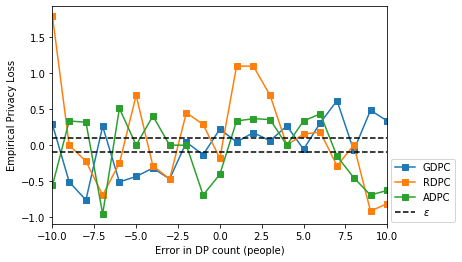

In [10]:
def simple_epl(dpc, method, exact_counts, K):
    """Find the log of probability ratio for errors of -K to K
    Parameters
    ----------
    dpc : dict of replicates of DP counts
    method : str, one of GDPC, RDPC, ADPC
    exact_counts : np.array of exact total counts
    K : int
    
    Results
    -------
    returns np.array of log-ratios
    
    """
    dpc_D = np.array([dpc[method, r, "D"].iloc[0] for r in range(R)])
    dpc_Dp = np.array([dpc[method, r, "D'"].iloc[0] for r in range(R)])
    
    epl = {}
    for k in range(-K, K+1):
        p_D = np.mean(np.round(dpc_D - exact_counts.iloc[0]) == k)
        p_Dp = np.mean(np.round(dpc_Dp - exact_counts.iloc[0]) == k)
        epl[k] = np.log(p_D/p_Dp)
    return pd.Series(epl)

for method in 'GDPC RDPC ADPC'.split():
    simple_epl(dpc, method, exact_counts, 10).plot(marker='s', label=method)
plt.axhline(float(epsilon), color='k', linestyle='--', label='$\epsilon$')
plt.axhline(-float(epsilon), color='k', linestyle='--')
plt.xlabel('Error in DP count (people)')
plt.ylabel('Empirical Privacy Loss')
plt.legend(loc=(1.01, .01));

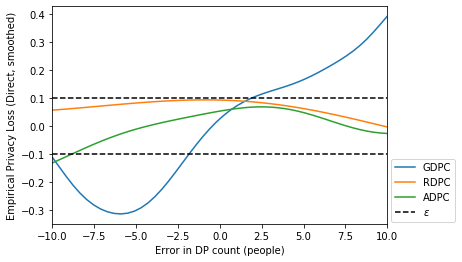

In [11]:
import scipy.stats

def smoothed_epl(dpc, method, exact_counts, K, bandwidth):
    """Find the log of probability ratio for errors of -K to K
    Parameters
    ----------
    dpc : dict of replicates of DP counts
    method : str, one of GDPC, RDPC, ADPC
    exact_counts : np.array of exact total counts
    K : int
    bandwidth : float
    
    Results
    -------
    returns np.array of log-ratios
    
    """
    dpc_D = np.array([dpc[method, r, "D"].iloc[0] for r in range(R)])
    dpc_Dp = np.array([dpc[method, r, "D'"].iloc[0] for r in range(R)])
    
    error_D = (dpc_D - exact_counts.iloc[0])
    error_Dp = (dpc_Dp - exact_counts.iloc[0])
    
    p_tilde_D = scipy.stats.gaussian_kde(error_D, bw_method=bandwidth)
    p_tilde_Dp = scipy.stats.gaussian_kde(error_Dp, bw_method=bandwidth)
    
    k_array = np.linspace(-K, K)
    epl = np.log(p_tilde_D(k_array) / p_tilde_Dp(k_array))

    return pd.Series(epl, index=k_array)

for method in 'GDPC RDPC ADPC'.split():
    smoothed_epl(dpc, method, exact_counts, 10, .15).plot(label=method)
plt.axhline(float(epsilon), color='k', linestyle='--', label='$\epsilon$')
plt.axhline(-float(epsilon), color='k', linestyle='--')
plt.xlabel('Error in DP count (people)')
plt.ylabel('Empirical Privacy Loss (Direct, smoothed)')
plt.legend(loc=(1.01, .01));

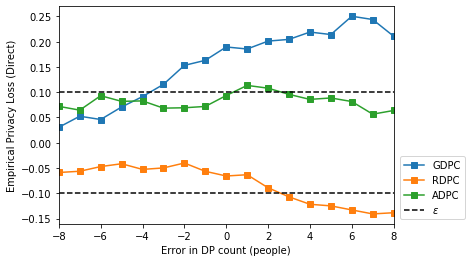

In [12]:
def simple_epl_2(dpc, method, exact_counts, K):
    """Find the log of probability ratio for errors of -K to K
    Parameters
    ----------
    dpc : dict of replicates of DP counts
    method : str, one of GDPC, RDPC, ADPC
    exact_counts : np.array of exact total counts
    K : int
    
    Results
    -------
    returns np.array of log-ratios
    
    """
    dpc_D = np.array([dpc[method, r, "D"].iloc[0] for r in range(R)])
    dpc_Dp = np.array([dpc[method, r, "D'"].iloc[0] for r in range(R)])
    
    epl = {}
    for k in range(-K, K+1):
        p_D = np.mean(np.round(dpc_D - exact_counts.iloc[0]) >= k)
        p_Dp = np.mean(np.round(dpc_Dp - exact_counts.iloc[0]) >= k)
        epl[k] = np.log(p_D/p_Dp)
    return pd.Series(epl)

for method in 'GDPC RDPC ADPC'.split():
    simple_epl_2(dpc, method, exact_counts, 8).plot(marker='s', label=method)
plt.axhline(float(epsilon), color='k', linestyle='--', label='$\epsilon$')
plt.axhline(-float(epsilon), color='k', linestyle='--')
plt.xlabel('Error in DP count (people)')
plt.ylabel('Empirical Privacy Loss (Direct)')
plt.legend(loc=(1.02, .02));

# Less-obvious estimate:

Because of the special structure of count queries, there is a way to avoid re-running the DP algorithm repeatedly.  This can be particularly useful for assessing the empirical privacy loss of complex algorithms like TopDown. If the difference between the DP count and the exact count was identically distributed for all areal units, then instead of focusing on only the areal units containing the individual who's changed, we could use the residuals for all areal units to estimate the probability of the event we are after:
$$\Pr\left[\mathrm{error}_{j_1, j_2, \ldots, j_{J}}^D
= k\right]
\approx
\bigg(\sum_{j_1'=1}^C\sum_{j_2'=1}^C\cdots\sum_{j_J' = 1}^C \mathbf{1}\left[\left\{\mathrm{error}_{j_1', j_2', \ldots, j_{J}'}^D
= k\right\}\right]\bigg)\bigg/C^J =: \hat{p}_k,
$$
and $$\mathrm{error}_{j_1, j_2, \ldots, j_{J}}^D = \left(\mathcal{A}(D)_{j_1, j_2, \ldots, j_{J'}}
- \mathrm{TC}_{j_1, j_2, \ldots, j_{J'}}\right),$$
where $\mathcal{A}(D)$ is the vector of DP counts returned by the GDPC, RDPC, or ADPC algorithm.

We can make this estimate with more precision than the direct estimate, using substantially less computation.

It is also possible to make an estimate of the probability $D'$ yields error of $k$ without repeatedly running the DP algorithm.  This relies on the observation that, for count queries, a change to a single row of data can change the exact count by at most one for any areal unit.  Therefore
$$
\Pr\left[\mathrm{error}_{j_1, j_2, \ldots, j_{J}}^{D'}
= k\right]
\gtrapprox
\begin{cases}
\Pr\left[\mathrm{error}_{j_1, j_2, \ldots, j_{J}}^{D}
= k+1\right], \qquad \text{ if } k \geq 0;\\[.1in]
\Pr\left[\mathrm{error}_{j_1, j_2, \ldots, j_{J}}^{D}
= k-1\right], \qquad \text{ if } k \leq 0;
\end{cases}
$$
which we can also approximate by examining the residuals for all areal units:
$$\Pr\left[\mathrm{error}_{j_1, j_2, \ldots, j_{J}}^{D'}
= k\right]
\gtrapprox 
\bigg(\sum_{j_1'=1}^C\sum_{j_2'=1}^C\cdots\sum_{j_J' = 1}^C \mathbf{1}\left[\left\{\mathrm{error}_{j_1', j_2', \ldots, j_{J}'}^D
= k\pm 1\right\}\right]\bigg)\bigg/C^J.
$$
With these estimate in mind, I ran GDPC and RDPC for a range of databases $D$, with multiple values of $N$, $J$, $\mu$, and $\epsilon$ and calculated $\log \hat{p}_k / \hat{p}_{k-1}$ for all $|k| \leq K$. I used the maximum log-ratio as an empirical comparator with the theoretical privacy loss $\epsilon$.  I also searched for the appropriate value of $K$ to bound the range of residuals, which I parameterized by selecting a residual percentile and scaling factor (e.g. take $K$ to be $1.5$ times the $95$-th percentile of the residuals).

As with the direct estimates, I found that the stochastic noise in $\hat{p}_k$ led to undesirable fluctuations in the empirical privacy loss bounds, and to address this, I used Gausian kernel density estimates to smooth the approximations of $\hat{p}(k)$ as a function of $k$.  I experimented with a range of bandwidth parameters for the Gaussian, and used $\log \hat{p}(k) / \hat{p}(k+1)$ to create a less noisy estimate of the empirical privacy loss.

In [13]:
def empirical_privacy_loss(error, bandwidth=0.1, est_range_percentile=99, est_range_multiplier=1.5):
    """Calculate the empirical privacy loss based on observed measurement errors

    Parameters
    ----------

    error : pd.Series of measurement errors
    bandwidth : float, optional, passed as bw_method parameter in
                scipy.stats.gaussian_kde
    est_range_percentile : float, optional, used as upperbound and
                           100-lowerbound percentile for estimation range
    est_range_multiplier : float, optional, used to scale percentile
                           bound for estimation range

    Results
    -------

    returns pd.DataFrame of EPL and histogram, as well as smoothed versions

    """
    lb = np.percentile(error, 100-est_range_percentile)
    ub = np.percentile(error, est_range_percentile)
    bnd = est_range_multiplier*max(abs(lb), abs(ub))

    est_range = [-bnd, bnd]
    all_errors = error.values
    N = len(all_errors)

    f_empirical, bin_edges = np.histogram(all_errors, bins=np.arange(*est_range, 1))
    ratio = f_empirical[:-1] / f_empirical[1:]

    df = pd.DataFrame(index=.5*(bin_edges[:-2] + bin_edges[1:-1]))
    df['hist'] = f_empirical[:-1]
    df['epl_hist'] = np.log(ratio)

    ccusum = f_empirical.sum() - np.cumsum(f_empirical)
    df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])

    if np.allclose(all_errors, 0):
        # can't do kde of all zeros
        df['smooth_hist'] = np.nan * np.ones_like(bin_edges[:-1])
        df['smooth_epl'] = np.inf * np.ones_like(bin_edges[:-1])
    else:
        kernel = scipy.stats.gaussian_kde(all_errors, bw_method=bandwidth)
        f_smoothed = N*kernel(.5 * (bin_edges[:-1] + bin_edges[1:]))
        ratio = f_smoothed[:-1] / f_smoothed[1:]
        df['smooth_hist'] = f_smoothed[:-1]
        df['smooth_epl'] = np.log(ratio)
    return df


In [14]:
%%time

df_epl = {}

bandwidth=0.15
est_range_percentile=95
est_range_multiplier=2.0

P = J+1 # chose parameter for ADPC to match RDPC parts
for epsilon in ['0.025', 
                '0.05', '0.1']:
    gdp_counts = GDPC(epsilon, exact_counts)
    df_epl[epsilon] = empirical_privacy_loss(
        exact_counts-gdp_counts, bandwidth, est_range_percentile, est_range_multiplier)

    rdp_counts = RDPC(epsilon, exact_counts)
    df_epl[f'{epsilon}_raked'] = empirical_privacy_loss(
        exact_counts-rdp_counts, bandwidth, est_range_percentile, est_range_multiplier)
    
    adp_counts = ADPC(epsilon, P, exact_counts)
    df_epl[f'{epsilon}_averaged'] = empirical_privacy_loss(
        exact_counts-adp_counts, bandwidth, est_range_percentile, est_range_multiplier)

/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/homes/abie/.conda/envs/dismod_mr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 22.2 s, sys: 204 ms, total: 22.4 s
Wall time: 22.3 s


# Visual comparison of error and EPL

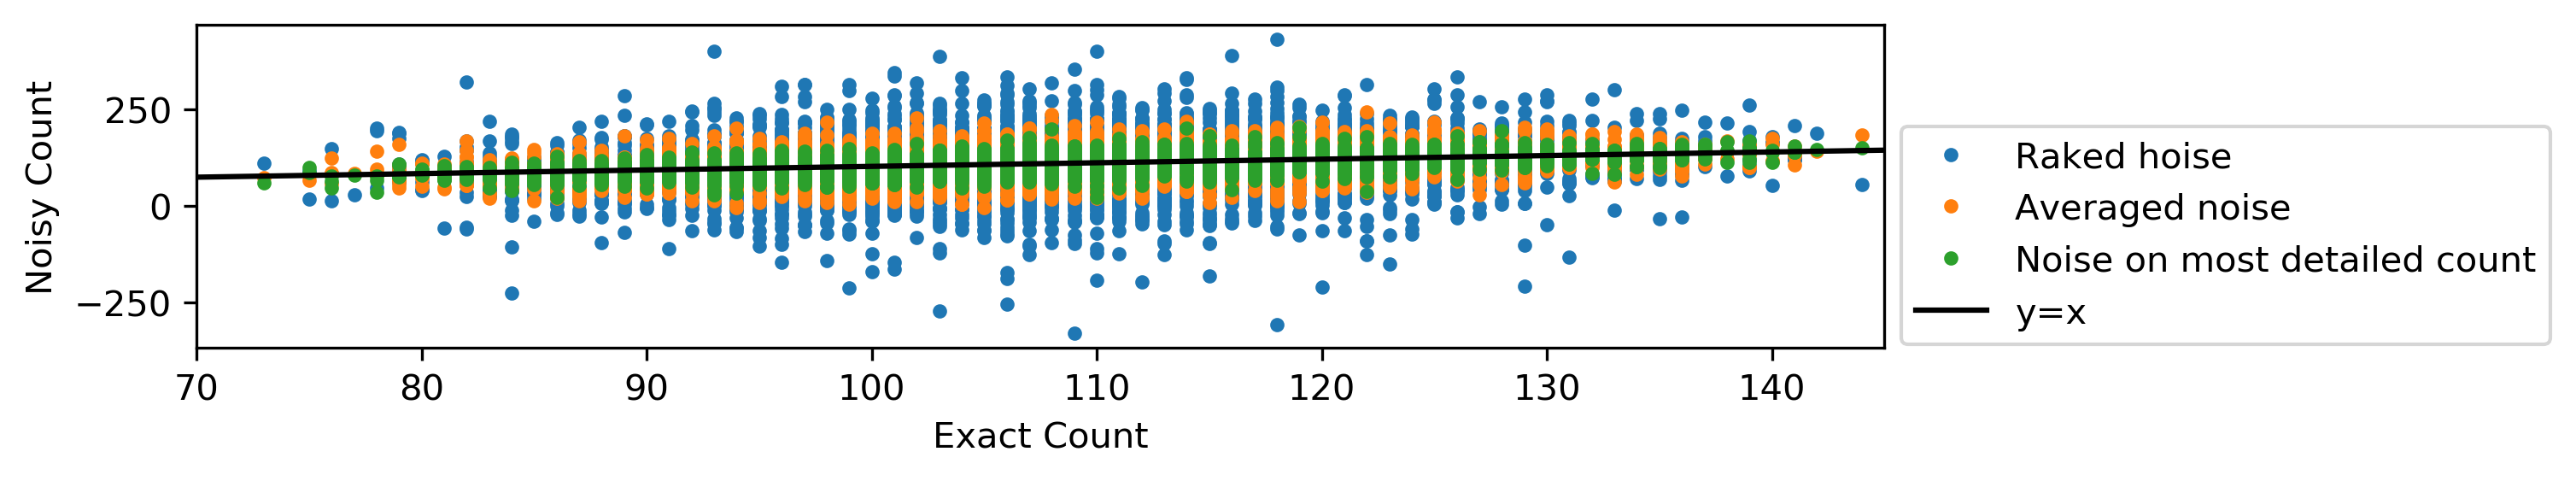

In [15]:
fig, ax = plt.subplots(ncols=1, figsize=(8.5, 2), dpi=300)
plt.subplots_adjust(wspace=.3, bottom=.25)

plt.plot(exact_counts, rdp_counts, '.', label='Raked hoise')
plt.plot(exact_counts, adp_counts, '.', label='Averaged noise')
plt.plot(exact_counts, gdp_counts, '.', label='Noise on most detailed count')

plt.xlabel('Exact Count')
plt.ylabel('Noisy Count')
plt.plot([70,145], [75,145], 'k-', label='y=x')
plt.axis(xmin=70, xmax=145)
plt.legend(loc=(1.01, .01));

In [16]:
def my_clean(eps):
    if '_' in eps:
        return eps.replace('_', ', ')
    else:
        return f'{eps}, geometric noise'

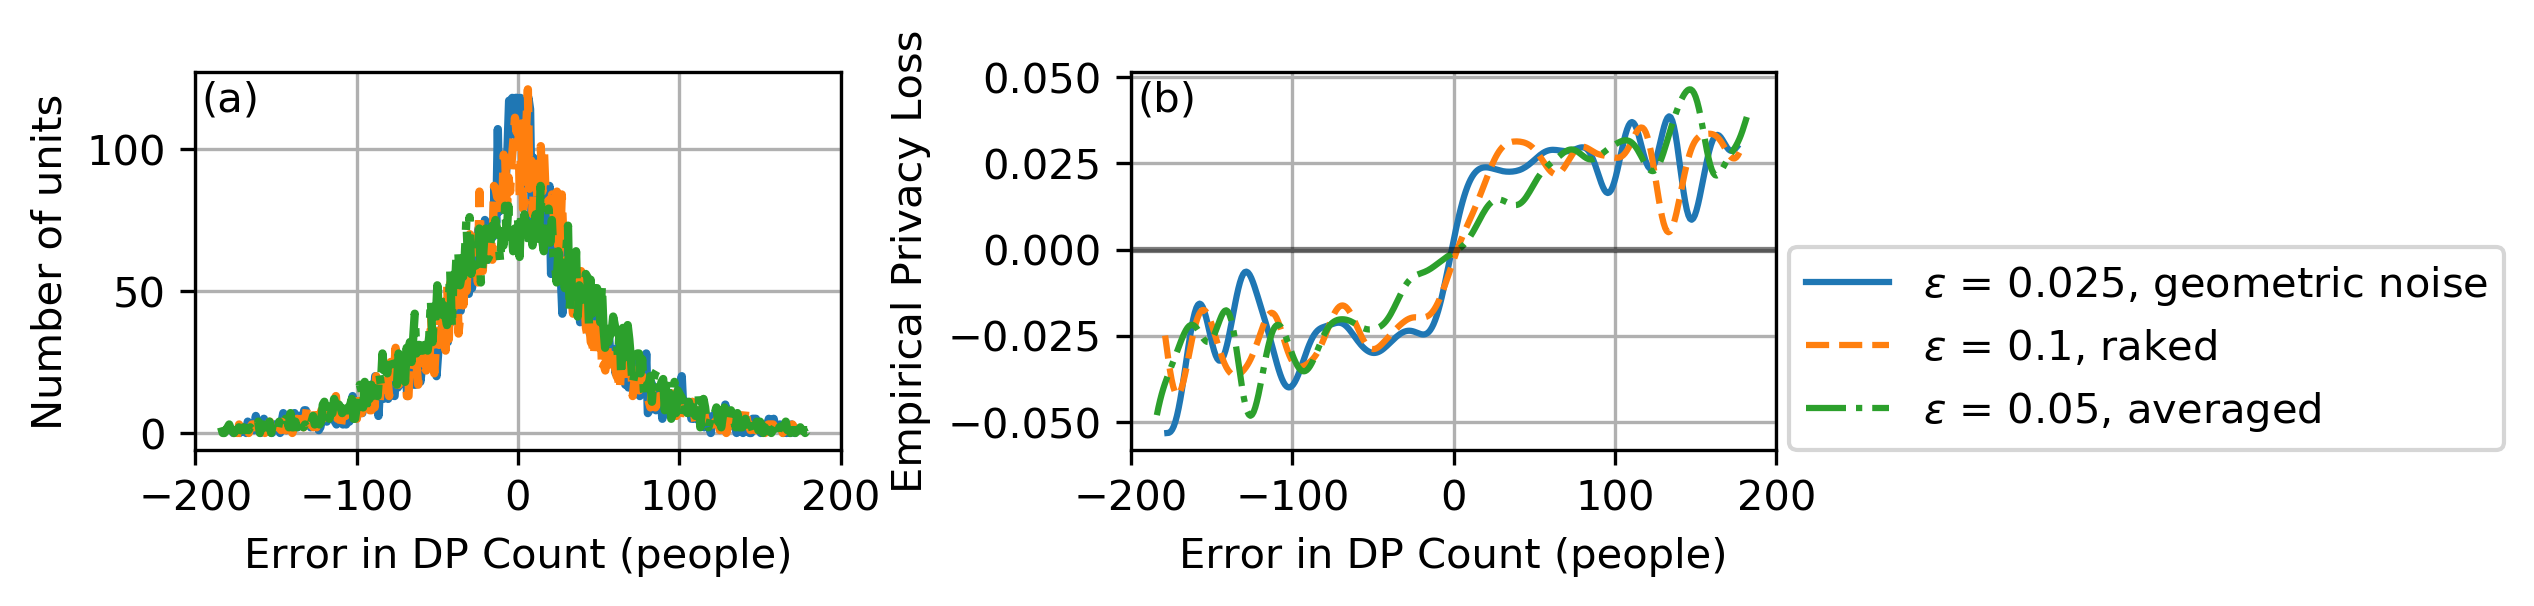

In [17]:
def my_plot(df_epl):
    xlim = 200
    
    fig, ax = plt.subplots(ncols=2, figsize=(8.5, 2), dpi=300)
    
    styles = ['-', '--', '-.']
    for i, eps in enumerate(['0.025', '0.1_raked', '0.05_averaged', ]):
        style = styles[i%3]
        ax[0].plot(df_epl[eps]['hist'].iloc[::1], linewidth=2, linestyle=style)
        ax[1].plot(df_epl[eps]['smooth_epl'], label=f'$\epsilon$ = {my_clean(eps)}', linestyle=style)

    ax[0].set_ylabel('Number of units')
    ax[0].set_xlabel('Error in DP Count (people)')
    ax[0].set_xlim(-xlim, xlim)
    ax[0].grid()
    ax[0].text(.01, .98, '(a)', transform=ax[0].transAxes, ha='left', va='top')

    ax[1].set_ylabel('Empirical Privacy Loss')
    ax[1].set_xlabel('Error in DP Count (people)')
    ax[1].axhline(0, color='k', alpha=.5)
    ax[1].set_xlim(-xlim, xlim)
    ax[1].set_yticks([-.05, -.025, 0, .025, .05])
    ax[1].grid()
    ax[1].text(.01, .98, '(b)', transform=ax[1].transAxes, ha='left', va='top')
    ax[1].legend(loc=(1.02, 0.0))
    
    plt.subplots_adjust(wspace=.45, bottom=.25, right=.7, left=.08)

my_plot(df_epl)
plt.savefig('/ihme/homes/abie/projects/2019/eqpl_w_examples/tex/fig.pdf')

In [18]:
!date

Mon Sep  9 16:58:15 PDT 2019
